In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect,and_

In [10]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo = False)

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with = engine)

In [14]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [16]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [18]:
#checking the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [20]:
#checking measurement table
columns= inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [22]:
#checking station table
columns= inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [28]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date

('2017-08-23',)

In [30]:
# checking my previous query
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

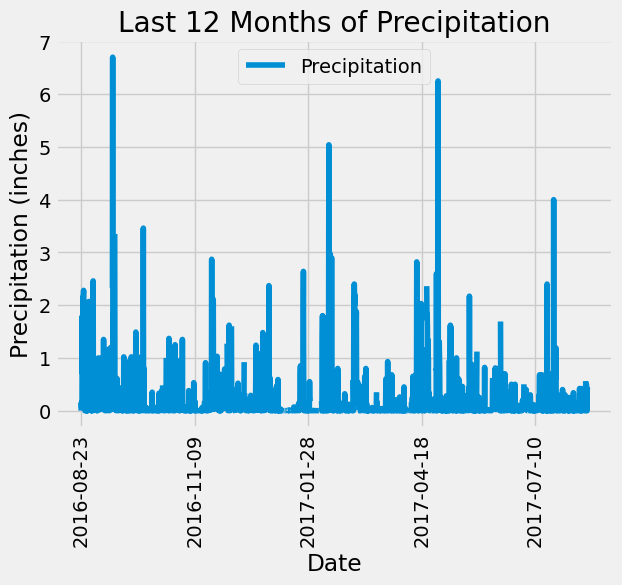

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
last_12_months = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_12_months).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_query, columns=["Date", "Precipitation"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x ='Date', y ='Precipitation', rot = 90)
plt.title("Last 12 Months of Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.show()

In [34]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df["Precipitation"].describe()
print("summary statistics")
print("--------------------")
print(summary_statistics)

summary statistics
--------------------
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [36]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.id)).all()

[(9,)]

In [56]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.id).label("count")
).group_by(Measurement.station) \
 .order_by(func.count(Measurement.id).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [68]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Query for the temperature statistics
most_active_station = 'USC00519281'
temperature_stats = (
    session.query(
        func.min(Measurement.tobs).label("min_temp"),
        func.max(Measurement.tobs).label("max_temp"),
        func.avg(Measurement.tobs).label("avg_temp")
    )
    .filter(Measurement.station == most_active_station)
    .one()
)

# Display temperature statistics
print(f"Temperature Stats for Station {most_active_station}:")
print(f"Lowest Temperature: {temperature_stats.min_temp}")
print(f"Highest Temperature: {temperature_stats.max_temp}")
print(f"Average Temperature: {temperature_stats.avg_temp}")

Temperature Stats for Station USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


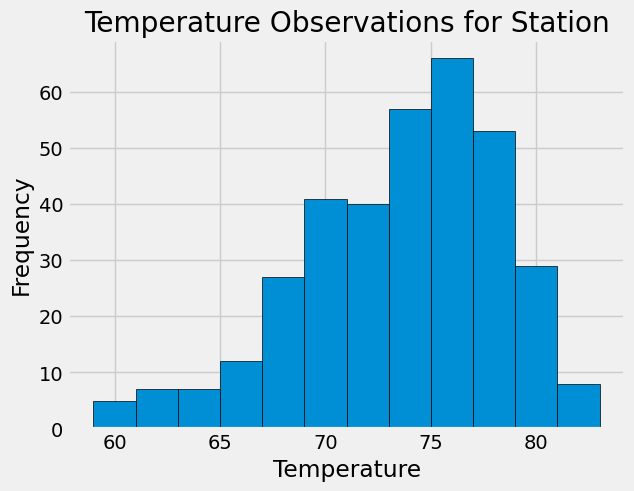

In [86]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == 'USC00519281')
    .filter(Measurement.date >= last_12_months)
    .all()
)

# Convert the query results into a list for plotting
temperature_data = [temp[0] for temp in result]

# Plot the results as a histogram
plt.hist(temperature_data, bins=12, edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Station')
plt.show()

# Close Session

In [88]:
# Close Session
session.close()